In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [55]:
import clmm
from clmm import Cosmology
import numpy as np
import math
import matplotlib.pyplot as plt

import sys  #
import h5py #
import matplotlib.pyplot as plt  #
import numpy as np  #T
import random  #
import pandas  #
from scipy import integrate, signal   #T
from scipy.stats import binned_statistic  #T
from scipy.stats import norm   #T
from scipy.special import erf   #T
import astropy   
import astropy.constants as const
import astropy.units as units
from astropy.io import fits
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import FlatwCDM
from IPython.display import clear_output
import os
import corner
import emcee
from multiprocessing import Pool
from matplotlib.pyplot import cm
import time as pytime

cosmo = Cosmology(H0=71.0, Omega_dm0=0.2248, Omega_b0=0.2648 - 0.2248, Omega_k0=0.0)

def Delta_Sigma_const(w, gamma1, Sigma_crit) :
	return w * Sigma_crit * gamma1 / w

def Delta_Sigma_4theta(w1, w2, gamma1, gamma2, theta, Sigma_crit) :
	return Sigma_crit * (w1*gamma1/np.cos(4*theta) + w2*gamma2/np.sin(4*theta)) / (w1 + w2)

def Delta_Sigma_4theta_cross(w1, w2, gamma1, gamma2, theta, Sigma_crit) :
	return Sigma_crit * (w1*gamma1/np.cos(4*theta) - w2*gamma2/np.sin(4*theta)) / (w1 + w2)

def Delta_Sigma_const_cross(w, gamma2, Sigma_crit) :
	return w*Sigma_crit*gamma2 / w

def weights(Sigma_crit, theta, Sigma_shape=0.0001, Sigma_meas=0) :
	## EQUATION 35, 32, 33
	w  = 1 / (Sigma_crit**2 * (Sigma_shape**2 + Sigma_meas**2))
	w1 = np.cos(4*theta)**2 * w
	w2 = np.sin(4*theta)**2 * w
	return w, w1, w2

def make_radial_bins(x, y, Nbins=10) :
	r = np.sqrt(x**2 + y**2)
	#r_bins = np.linspace(np.min(r), np.max(r), Nbins+1)
	rbin_edges = np.logspace(np.log10(0.4), np.log10(2.5), Nbins+1)
	inds = np.digitize(r, rbin_edges, right=True) - 1
	rbin_mean = np.array([np.mean(r[inds==i]) for i in range(Nbins)])
	return r, rbin_edges, rbin_mean, inds

def make_estimators(gamma1, gamma2, x_arcsec, y_arcsec, z_cl=0.47, sigma_c=3.77988e+15, method=1):
    sigma_c = cosmo.eval_sigma_crit(0.47,0.8)
    r = np.sqrt((x_arcsec**2 + y_arcsec**2))
    theta = np.arctan2(y_arcsec, x_arcsec)
    #theta = theta - np.pi/2
    r_mpc = r*cosmo.eval_da(z_cl) * np.pi/180.0 * 1/3600#0.00588784182755241#
    
    w, w1, w2 = weights(sigma_c, theta)
    DS4theta = Delta_Sigma_4theta(w1, w2, gamma1, gamma2, theta, sigma_c)
    DSconst = Delta_Sigma_const(w, gamma1, sigma_c)
    
    bins=15
        
    r_min = 0.4 #Normally 0.4
    r_max = 2.5
    bin_edges = np.logspace(np.log10(r_min), np.log10(r_max), bins)
    N_i = []
    for i in np.arange(bins-1):
        N_i.append(len(r_mpc[(r_mpc > bin_edges[i]) & (r_mpc < bin_edges[i+1])]))
    N_i=np.array(N_i)


    result = binned_statistic(r_mpc, gamma1, statistic='mean', bins=bin_edges)
    gamma1_i = result.statistic
    res = binned_statistic(r_mpc, gamma2, statistic='mean', bins=bin_edges)
    gamma2_i = res.statistic
    res = binned_statistic(r_mpc, DS4theta, statistic='mean', bins=bin_edges)
    DS4theta_i_err = binned_statistic(r_mpc, DS4theta, statistic='std', bins=bin_edges).statistic/np.sqrt(N_i)
    DS4theta_i = res.statistic
    res = binned_statistic(r_mpc, DSconst, statistic='mean', bins=bin_edges)
    DSconst_i = res.statistic
    DSconst_i_err = binned_statistic(r_mpc, DSconst, statistic='std', bins=bin_edges).statistic/np.sqrt(N_i)
    #print(bin_edges)
    r_i = bin_edges #+ (bin_edges[1]-bin_edges[0])/2
    #print(r_i)

    r_min = 0.3 #Normally 0.4
    r_max = 2.5
    bins_mono=15 #Need more bins always since, if r bin is too thick then averaging doesnt work for shear
    bin_edges = np.logspace(np.log10(r_min), np.log10(r_max), bins_mono)
    #print(bin_edges)
    N_i = []
    for i in np.arange(bins_mono-1):
        N_i.append(len(r_mpc[(r_mpc > bin_edges[i]) & (r_mpc < bin_edges[i+1])]))
    N_i=np.array(N_i)

    r_mono = bin_edges #+ (bin_edges[1]-bin_edges[0])/2
    res = binned_statistic(r_mpc, gamma1*np.cos(2*theta), statistic='mean', bins=bin_edges)
    gammat_mono = -2*res.statistic
    ds_mono_err = 2*binned_statistic(r_mpc, gamma1*np.cos(2*theta), statistic='std', bins=bin_edges).statistic/np.sqrt(N_i)*sigma_c
    ds_mono = gammat_mono*sigma_c
    
    '''
    ind = np.invert(np.isnan(ds_mono) | np.isnan(ds_mono_err))
    ds_mono = ds_mono[ind]
    ds_mono_err = ds_mono_err[ind]
    r_mono = np.sqrt(r_mono[:-1]*r_mono[1:])     [ind]
    ind = (ds_mono!= 0.0) & (ds_mono_err!= 0.0)
    ds_mono = ds_mono[ind]
    ds_mono_err = ds_mono_err[ind] 
    r_mono = r_mono[ind] 
    
    ind = np.invert(np.isnan(DS4theta_i) | np.isnan(DS4theta_i_err) | np.isnan(DSconst_i) | np.isnan(DSconst_i_err))
    DS4theta_i = DS4theta_i[ind]
    DS4theta_i_err = DS4theta_i_err[ind]
    DSconst_i = DSconst_i[ind] 
    DSconst_i_err = DSconst_i_err[ind]
    r_i = np.sqrt(r_i[:-1]*r_i[1:])[ind]
    '''
    r_mono = np.sqrt(r_mono[:-1]*r_mono[1:])
    r_i = np.sqrt(r_i[:-1]*r_i[1:])
    
    return ds_mono,np.abs(ds_mono_err),r_mono,DS4theta_i,np.abs(DS4theta_i_err),DSconst_i,np.abs(DSconst_i_err),r_i
    

## Calculation Steps
1. Create a triaxial halo given a model (use Shenming's catalog). Asssumes different ratio, pick 0.5 (to start)
2. Create axis-aligned profile at 0 degrees $\theta$ and $\phi$ ($\Delta\Sigma$)
3. Create another one at an arbitrary angle (90); should look fairly symmetric (along $\phi$)
4. Do it both perpindicular to and along line of sight expect a and b to be fairly identical
5. Write a function that can construct this for an arbitrary angle (rotation function); test for 45 degrees
6. Create for angles uniformly sampled between 0 and 90 (probably use a numpy function aka linspace)
7. Stack this and measure (of all the uniform)
8. Afterwards, do it for an arbitrary distribution of angles (drawing from uniform distribution and test)
9. Test for skewed Gaussian, something different, put it in as a keyword argument to function
10. Then I have a function that takes in triaxial model and ratio, and gives a ratio in theta

**Halo Catalog**

Reading in one of Shenming's $q=0.5$ halo shears. 

In [86]:
## reading in a file for a given axis ratio, q
q = 0.3
fname = "Elliptical_lenses_data/catalog_horizontal_rescale_q"+str(q)+"/"

## pulling out the appropriate variables: shears and positions
gamma1 = np.load(fname+"gamma1.npy").flatten()
gamma2 = np.load(fname+"gamma2.npy").flatten()

x_arcsec = np.load(fname+"x_arcsec.npy").flatten()
y_arcsec = np.load(fname+"y_arcsec.npy").flatten()

## calculating the angled position at each spot in radians
th = np.arctan2(x_arcsec, y_arcsec)

**Axis-Aligned Profile**

This catalog has the major axis oriented with the x axis. 

In [87]:
## size of slices
th_cut = np.radians(30)

## creating a major/minor axis cut
maj_cut = np.where( ((th >= (-1*th_cut)) & (th <= (th_cut))) | ((th >= (np.pi-th_cut)) & (th <= (np.pi+th_cut))) )
min_cut = np.where( ((th >= (np.pi/2-th_cut)) & (th <= (np.pi/2+th_cut))) | ((th >= (-np.pi/2-th_cut)) & (th <= (-np.pi+th_cut))) )

In [88]:
## cutting
gamma1_maj = gamma1[maj_cut]
gamma1_min = gamma1[min_cut]

gamma2_maj = gamma2[maj_cut]
gamma2_min = gamma2[min_cut]

x_as_maj = x_arcsec[maj_cut]
y_as_maj = y_arcsec[maj_cut]

x_as_min = x_arcsec[min_cut]
y_as_min = y_arcsec[min_cut]

## calculating delta sigma along the axes
mono,mono_err,r,quad_4theta,quad_4theta_err, quad_const,quad_const_err,r_quad = make_estimators(gamma1, gamma2, 
                                                x_arcsec, y_arcsec, z_cl=0.47, sigma_c=3.77988e+15)

mono_maj,mono_maj_err,r_maj,quad_4theta_maj,quad_4theta_maj_err, quad_const_maj,quad_const_maj_err,r_quad = make_estimators(gamma1_maj, gamma2_maj, 
                                                x_as_maj, y_as_maj, z_cl=0.47, sigma_c=3.77988e+15)

mono_min,mono_min_err,r_min,quad_4theta_min,quad_4theta_min_err, quad_const_min,quad_const_min_err,r_quad = make_estimators(gamma1_min, gamma2_min, 
                                                x_as_min, y_as_min, z_cl=0.47, sigma_c=3.77988e+15)

## getting the total by adding the multipole moments together

ds_full = mono+quad_4theta+quad_const
ds_maj = mono_maj + quad_4theta_maj + quad_const_maj
ds_min = mono_min + quad_4theta_min + quad_const_min

ds_full_err = np.sqrt(mono_err**2+quad_4theta_err**2+quad_const_err**2)
ds_maj_err = np.sqrt(mono_maj_err**2+quad_4theta_maj_err**2+quad_const_maj_err**2)
ds_min_err = np.sqrt(mono_min_err**2+quad_4theta_min_err**2+quad_const_min_err**2)

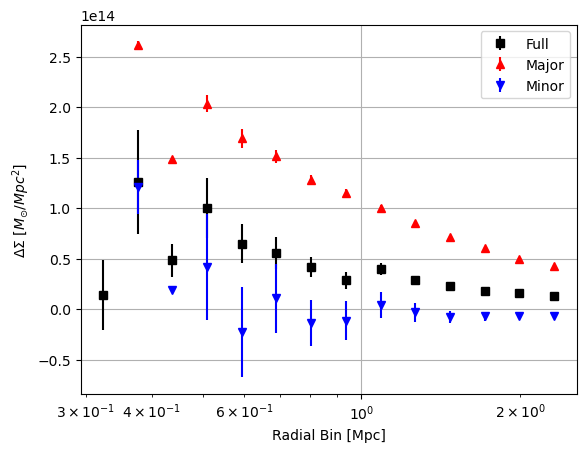

In [92]:
plt.errorbar(r, ds_full, yerr=ds_full_err, label='Full', color='black', marker='s', linestyle='None')
plt.errorbar(r_maj, ds_maj, yerr=ds_maj_err, label='Major', color='red', marker='^', linestyle='None')
plt.errorbar(r_min, ds_min, yerr=ds_min_err, label='Minor', color='blue', marker='v', linestyle='None')
plt.xlabel('Radial Bin [Mpc]')
plt.ylabel(r'$\Delta\Sigma$ [$M_{\odot}/Mpc^2$]')
plt.legend()
plt.xscale('log')
plt.grid()
plt.show()

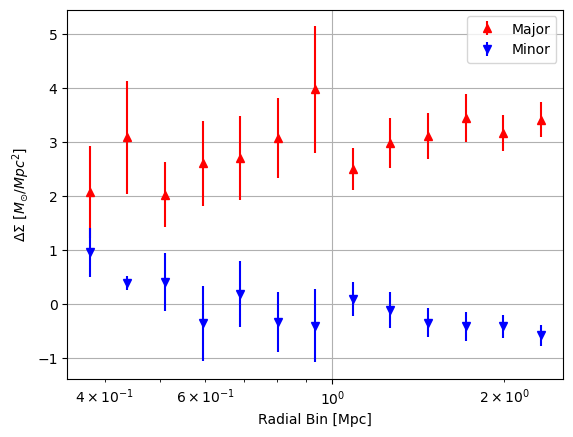

In [91]:
## plotting the ratio of the plots
maj_ratio = ds_maj/ds_full
min_ratio = ds_min/ds_full

maj_ratio_err = maj_ratio*np.sqrt( (ds_maj_err/ds_maj)**2 + (ds_full_err/ds_full)**2 )
min_ratio_err = min_ratio*np.sqrt( (ds_min_err/ds_min)**2 + (ds_full_err/ds_full)**2 )

plt.errorbar(r_maj, maj_ratio, yerr=np.abs(maj_ratio_err), label='Major', color='red', marker='^', linestyle='None')
plt.errorbar(r_min, min_ratio, yerr=np.abs(min_ratio_err), label='Minor', color='blue', marker='v', linestyle='None')
plt.xlabel('Radial Bin [Mpc]')
plt.ylabel(r'$\Delta\Sigma$ [$M_{\odot}/Mpc^2$]')
plt.legend()
plt.grid()
plt.xscale('log')
plt.show()

**90 degree rotation along $\phi$**

Both Perpindicular and along line-of-sight

**Uniformly Sampled Rotation**

**Arbitrary Distribution**

Draw from an arbitrary distribution and test

**Skewed Distribution**

Drawing from a Skewed Gaussian distribution. 